<h1>[GD_01]ResNet_Ablation_Study</h1>

2015년 ResNet을 소개한 논문에서 ResNet-18, 34, 50, 101, 152의 다섯 가지 네트워크를 소개합니다. 이 중 ResNet-34와 50을 구현해 보겠습니다.

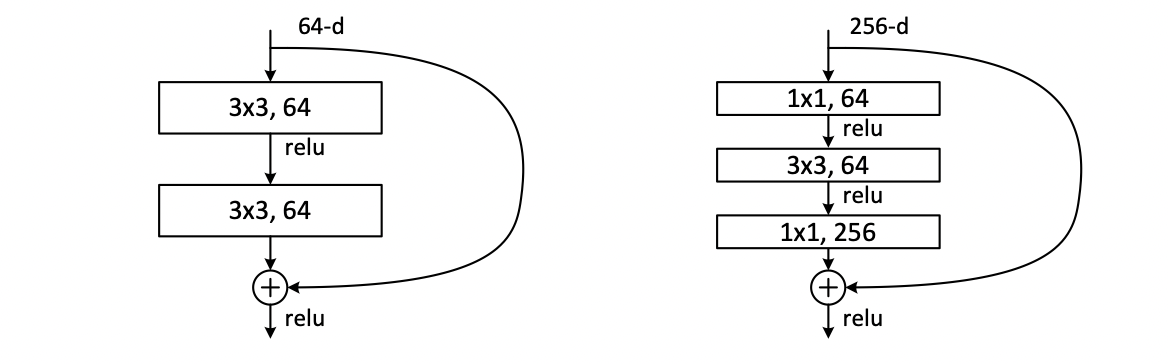

<h2>Import Libraries</h2>

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend, regularizers, initializers, models

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

Tensorflow가 활용할 GPU가 장착되어 있는지 확인해보겠습니다

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h2>Load Data</h2>

In [3]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

In [4]:
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
     

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /aiffel/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요.

In [5]:
 print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


데이터의 개수도 확인해봅니다

In [6]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [7]:
ds_info.features['label'].num_classes

2

In [8]:
ds_info.features['label'].names

['cat', 'dog']

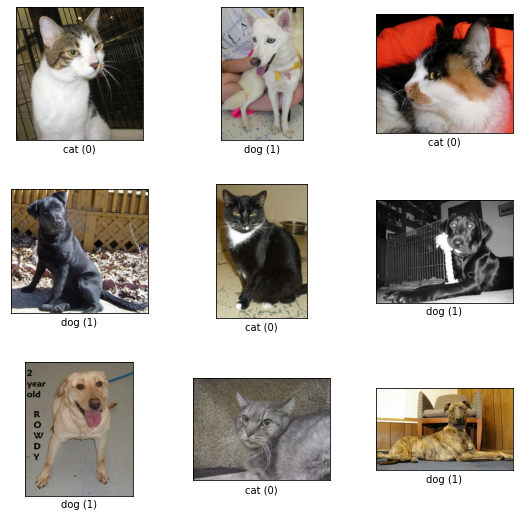

In [9]:
fig = tfds.show_examples(ds_train, ds_info)

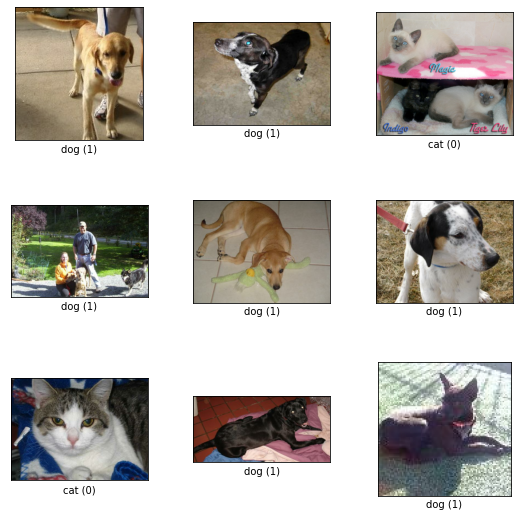

In [10]:
fig = tfds.show_examples(ds_test, ds_info)

<h2>Normalization</h2>

In [11]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, (224,224))
    image = tf.cast(image, tf.float32) / 255.
    return image, label

In [12]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    #ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

<h2>1) ResNet 기본 블록 구성하기</h2>

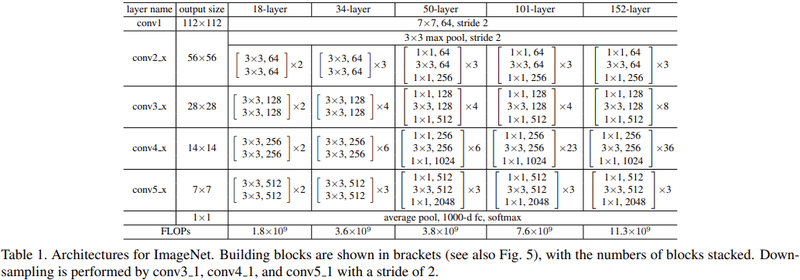

<h3>ResNet-34와 ResNet-50의 공통점과 차이점</h3>

ResNet-34와 ResNet-50은 모두 conv block이라고 불리는 블록 구조를 각각 3, 4, 6, 3개씩 반복해서 쌓은 형태라는 공통점을 가지고 있습니다. 그러나 ResNet-34와 ResNet-50의 블록 내부 구성은 약간 다릅니다. ResNet-34의 경우 Block은 3x3 kernel인 Convolution layer로만 구성되어있지만, ResNet-50은 1x1 Convolution이 앞뒤로 붙어 더 많은 레이어를 한 블록 내에 가지게 됩니다.

In [13]:
def conv_block(input_layer, 
               channel, 
               kernel_size, 
               strides=1, 
               activation='relu'):
    
    x = keras.layers.Conv2D(filters=channel,
                            kernel_size=kernel_size,
                            kernel_initializer='he_normal',
                            kernel_regularizer=keras.regularizers.l2(1e-4),
                            padding='same',
                            strides=strides
                           )(input_layer)
    
    x = keras.layers.BatchNormalization()(x)
    
    if activation:
        x = keras.layers.Activation(activation)(x)
    
    return x

In [14]:
def build_resnet_block(input_layer, 
                       num_cnn=3, 
                       channel=64, 
                       block_num=0, 
                       is_50=True):
    
    x = input_layer
    
    # ResNet-50
    if is_50:
        for i in range(num_cnn):
            if i == 0:
                shortcut = conv_block(x, channel*4, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    
    # ResNet-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                shortcut = conv_block(x, channel, (1,1), strides=2, activation=None)
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3), activation=None)
            else:
                shortcut = x
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3), activation=None)
            
            x = keras.layers.Add()([x, shortcut])
            x = keras.layers.Activation('relu')(x)
    

    return x

In [15]:
def build_resnet(input_shape=(32,32,3),
                 num_cnn_list=[3,4,6,3],
                 channel_list=[64,128,256,512],
                 num_classes=2, 
                 is_50=True, 
                 activation='softmax',
                 name='ResNet_50'):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 Residual block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_resnet_block(x, 
                               num_cnn=num_cnn, 
                               channel=channel, 
                               block_num=block_num, 
                               is_50=is_50)
        
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation, 
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

<h2>2) ResNet-34, ResNet-50 Complete Model</h2>

<h3>ResNet-34</h3>

In [16]:
resnet_34 = build_resnet(input_shape=(224,224,3), is_50=False, activation='relu', name='ResNet_34')
resnet_34.summary()

Model: "ResNet_34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
__________________________________________________________________________________________

<h3>ResNet-50</h3>

In [17]:
resnet_50 = build_resnet(input_shape=(224,224,3), is_50=True, activation='relu', name='ResNet_50')
resnet_50.summary()

Model: "ResNet_50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_36 (BatchNo (None, 112, 112, 64) 256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
activation_33 (Activation)      (None, 112, 112, 64) 0           batch_normalization_36[0][0]     
__________________________________________________________________________________________

<h2>3) 일반 네트워크(plain network) 만들기</h2>

In [18]:
def build_plain_block(input_layer, 
                      num_cnn=3, 
                      channel=64, 
                      block_num=0, 
                      is_50=True):
    
    x = input_layer
    
    # plain-50
    if is_50:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (1,1), strides=2)
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
            else:
                x = conv_block(x, channel, (1,1))
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel*4, (1,1))
    
    # plain-34
    else:
        for i in range(num_cnn):
            if block_num > 0 and i == 0:
                x = conv_block(x, channel, (3,3), strides=2)
                x = conv_block(x, channel, (3,3))
            else:
                x = conv_block(x, channel, (3,3))
                x = conv_block(x, channel, (3,3))

    return x

In [19]:
def build_plain(input_shape=(32,32,3), 
                   num_cnn_list=[3,4,6,3],
                   channel_list=[64,128,256,512],
                   num_classes=10,
                   is_50=True, 
                   activation='softmax',
                   name='Plain_50'):
    
    assert len(num_cnn_list) == len(channel_list)
    
    input_layer = keras.layers.Input(shape=input_shape)
    
    # first layer
    x = conv_block(input_layer, 64, (7,7), strides=2)
    x = keras.layers.MaxPool2D(pool_size=(2,2), strides=2)(x)
    
    # config list들의 길이만큼 반복해서 plain block 블록을 생성합니다.
    for block_num, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        x = build_plain_block(x, 
                              num_cnn=num_cnn, 
                              channel=channel,
                              block_num=block_num,
                              is_50=is_50)
    
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(num_classes, 
                           activation=activation,
                           kernel_initializer='he_normal'
                          )(x)
    
    model = keras.Model(inputs=input_layer, outputs=x, name=name)
    
    return model

<h3>Plain-34</h3>

In [20]:
plain_34 = build_plain(input_shape=(224,224,3), is_50=False, activation='relu', name='Plain_34')
plain_34.summary()

Model: "Plain_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_89 (Batc (None, 112, 112, 64)      256       
_________________________________________________________________
activation_82 (Activation)   (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 56, 56, 64)        36928     
_________________________________________________________________
batch_normalization_90 (Batc (None, 56, 56, 64)        256

<h3>Plain-50</h3>

In [21]:
plain_50 = build_plain(input_shape=(224,224,3), is_50=True, activation='relu', name='Plain_50')
plain_50.summary()

Model: "Plain_50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_122 (Conv2D)          (None, 112, 112, 64)      9472      
_________________________________________________________________
batch_normalization_122 (Bat (None, 112, 112, 64)      256       
_________________________________________________________________
activation_115 (Activation)  (None, 112, 112, 64)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_123 (Conv2D)          (None, 56, 56, 64)        4160      
_________________________________________________________________
batch_normalization_123 (Bat (None, 56, 56, 64)        256

<h2>4) ResNet-50 vs Plain-50 또는 ResNet-34 vs Plain-34</h2>

·모델 학습<br>
·비교

In [22]:
BATCH_SIZE = 32
EPOCH = 10

In [23]:
# 데이터 정의

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

<h3>Plain-34 학습</h3>

In [24]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
     

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:28 - loss: 2.4800 - accuracy: 0.3938

 41/581 [=>............................] - ETA: 1:26 - loss: 2.4154 - accuracy: 0.4253

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:15 - loss: 2.2869 - accuracy: 0.4984

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 42s - loss: 2.2560 - accuracy: 0.5176

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 40s - loss: 2.2546 - accuracy: 0.5168

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 38s - loss: 2.2534 - accuracy: 0.5172

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 34s - loss: 2.2508 - accuracy: 0.5178

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 33s - loss: 2.2500 - accuracy: 0.5188

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 2.2368 - accuracy: 0.5302

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2368 - accuracy: 0.5302

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 137s 205ms/step - loss: 2.2368 - accuracy: 0.5302 - val_loss: 2.2164 - val_accuracy: 0.5287
Epoch 2/10
 30/581 [>.............................] - ETA: 1:33 - loss: 2.2131 - accuracy: 0.5542

 42/581 [=>............................] - ETA: 1:31 - loss: 2.2103 - accuracy: 0.5670

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:19 - loss: 2.2104 - accuracy: 0.5470

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 44s - loss: 2.2112 - accuracy: 0.5495

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 2.2113 - accuracy: 0.5502

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 40s - loss: 2.2111 - accuracy: 0.5513

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 35s - loss: 2.2109 - accuracy: 0.5495

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 2.2109 - accuracy: 0.5491

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2099 - accuracy: 0.5525

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2099 - accuracy: 0.5525 - val_loss: 2.2107 - val_accuracy: 0.5388
Epoch 3/10
  1/581 [..............................] - ETA: 1:38 - loss: 2.2330 - accuracy: 0.4375

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:34 - loss: 2.2086 - accuracy: 0.5479

 41/581 [=>............................] - ETA: 1:32 - loss: 2.2054 - accuracy: 0.5564

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 1:20 - loss: 2.2083 - accuracy: 0.5376

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 44s - loss: 2.2067 - accuracy: 0.5516

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 2.2070 - accuracy: 0.5496

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 2.2070 - accuracy: 0.5495

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 2.2069 - accuracy: 0.5503

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.2069 - accuracy: 0.5491

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2059 - accuracy: 0.5526

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.2059 - accuracy: 0.5526 - val_loss: 2.2058 - val_accuracy: 0.5175
Epoch 4/10
 32/581 [>.............................] - ETA: 1:33 - loss: 2.2030 - accuracy: 0.5693

 44/581 [=>............................] - ETA: 1:32 - loss: 2.1996 - accuracy: 0.5703

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:19 - loss: 2.2020 - accuracy: 0.5566

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 44s - loss: 2.2009 - accuracy: 0.5658

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 42s - loss: 2.2007 - accuracy: 0.5679

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 40s - loss: 2.2003 - accuracy: 0.5692

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 35s - loss: 2.2004 - accuracy: 0.5695

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 2.2006 - accuracy: 0.5683

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2005 - accuracy: 0.5687

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.2005 - accuracy: 0.5687 - val_loss: 2.1999 - val_accuracy: 0.5726
Epoch 5/10
  3/581 [..............................] - ETA: 1:38 - loss: 2.2024 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:33 - loss: 2.2032 - accuracy: 0.5846

 42/581 [=>............................] - ETA: 1:32 - loss: 2.2023 - accuracy: 0.5744

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:19 - loss: 2.1982 - accuracy: 0.5737

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 44s - loss: 2.2035 - accuracy: 0.5917

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 2.2033 - accuracy: 0.5916

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 39s - loss: 2.2039 - accuracy: 0.5929

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 35s - loss: 2.2060 - accuracy: 0.5950

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 34s - loss: 2.2056 - accuracy: 0.5955

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2052 - accuracy: 0.5976

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2052 - accuracy: 0.5976 - val_loss: 2.1953 - val_accuracy: 0.5946
Epoch 6/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.1973 - accuracy: 0.5781

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:33 - loss: 2.2519 - accuracy: 0.6071

 44/581 [=>............................] - ETA: 1:31 - loss: 2.2398 - accuracy: 0.6094

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:19 - loss: 2.2135 - accuracy: 0.6010

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 43s - loss: 2.1969 - accuracy: 0.6004

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 41s - loss: 2.1963 - accuracy: 0.6022

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 2.2000 - accuracy: 0.6019

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 35s - loss: 2.1992 - accuracy: 0.6019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 34s - loss: 2.1983 - accuracy: 0.6026

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2135 - accuracy: 0.6020

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.2135 - accuracy: 0.6020 - val_loss: 2.1829 - val_accuracy: 0.6147
Epoch 7/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.1738 - accuracy: 0.5938

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:32 - loss: 2.2456 - accuracy: 0.5800

 45/581 [=>............................] - ETA: 1:31 - loss: 2.2349 - accuracy: 0.5863

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 2.2595 - accuracy: 0.5954

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 2.2064 - accuracy: 0.6121

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 41s - loss: 2.2054 - accuracy: 0.6120

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 39s - loss: 2.2067 - accuracy: 0.6111

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.2061 - accuracy: 0.6092

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 2.2053 - accuracy: 0.6091

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.2111 - accuracy: 0.6129

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.2111 - accuracy: 0.6129 - val_loss: 2.1763 - val_accuracy: 0.6128
Epoch 8/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.1774 - accuracy: 0.6562

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:33 - loss: 2.2062 - accuracy: 0.6295

 48/581 [=>............................] - ETA: 1:31 - loss: 2.2105 - accuracy: 0.6243

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:19 - loss: 2.2513 - accuracy: 0.6193

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 43s - loss: 2.2759 - accuracy: 0.6102

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 41s - loss: 2.2799 - accuracy: 0.6102

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 39s - loss: 2.2901 - accuracy: 0.6100

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 2.3002 - accuracy: 0.6110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 2.3038 - accuracy: 0.6107

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3345 - accuracy: 0.6136

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 194ms/step - loss: 2.3345 - accuracy: 0.6136 - val_loss: 2.2063 - val_accuracy: 0.5807
Epoch 9/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.1053 - accuracy: 0.7031

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:33 - loss: 2.3216 - accuracy: 0.6351

 48/581 [=>............................] - ETA: 1:31 - loss: 2.3148 - accuracy: 0.6406

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:18 - loss: 2.3974 - accuracy: 0.6334

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 43s - loss: 2.4010 - accuracy: 0.6267

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 41s - loss: 2.3947 - accuracy: 0.6252

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 39s - loss: 2.3924 - accuracy: 0.6256

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.3986 - accuracy: 0.6279

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 2.3980 - accuracy: 0.6286

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3915 - accuracy: 0.6230

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.3915 - accuracy: 0.6230 - val_loss: 2.5020 - val_accuracy: 0.6227
Epoch 10/10
  8/581 [..............................] - ETA: 1:38 - loss: 2.3781 - accuracy: 0.6602

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:33 - loss: 2.3113 - accuracy: 0.6363

 50/581 [=>............................] - ETA: 1:31 - loss: 2.3349 - accuracy: 0.6488

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:19 - loss: 2.3947 - accuracy: 0.6397

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 43s - loss: 2.3460 - accuracy: 0.6425

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 41s - loss: 2.3495 - accuracy: 0.6414

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 39s - loss: 2.3538 - accuracy: 0.6404

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 34s - loss: 2.3553 - accuracy: 0.6398

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 33s - loss: 2.3581 - accuracy: 0.6397

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3489 - accuracy: 0.6356

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 197ms/step - loss: 2.3489 - accuracy: 0.6356 - val_loss: 2.7178 - val_accuracy: 0.6301


<h3>ResNet-34 학습</h3>

In [25]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)
     

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 1:39 - loss: 2.5499 - accuracy: 0.5268

 40/581 [=>............................] - ETA: 1:37 - loss: 2.5033 - accuracy: 0.5281

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:22 - loss: 2.4319 - accuracy: 0.5158

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 45s - loss: 2.4082 - accuracy: 0.5080

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 43s - loss: 2.4076 - accuracy: 0.5077

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 41s - loss: 2.4072 - accuracy: 0.5073

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 36s - loss: 2.4071 - accuracy: 0.5060

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 35s - loss: 2.4069 - accuracy: 0.5050

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 2.4016 - accuracy: 0.5045

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.4016 - accuracy: 0.5045

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 138s 200ms/step - loss: 2.4016 - accuracy: 0.5045 - val_loss: 2.3909 - val_accuracy: 0.4848
Epoch 2/10
 29/581 [>.............................] - ETA: 1:34 - loss: 2.3908 - accuracy: 0.4935

 41/581 [=>............................] - ETA: 1:32 - loss: 2.3908 - accuracy: 0.4954

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:21 - loss: 2.3905 - accuracy: 0.5030

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 44s - loss: 2.3898 - accuracy: 0.5005

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 42s - loss: 2.3897 - accuracy: 0.5001

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 2.3897 - accuracy: 0.5005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 36s - loss: 2.3896 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 35s - loss: 2.3896 - accuracy: 0.5036

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3889 - accuracy: 0.5058

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 122s 209ms/step - loss: 2.3889 - accuracy: 0.5058 - val_loss: 2.3870 - val_accuracy: 0.4889
Epoch 3/10
  1/581 [..............................] - ETA: 1:39 - loss: 2.3870 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:34 - loss: 2.3869 - accuracy: 0.5063

 42/581 [=>............................] - ETA: 1:32 - loss: 2.3868 - accuracy: 0.5015

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:20 - loss: 2.3866 - accuracy: 0.5046

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 44s - loss: 2.3859 - accuracy: 0.5004

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 2.3859 - accuracy: 0.5011

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 40s - loss: 2.3858 - accuracy: 0.5005

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 35s - loss: 2.3857 - accuracy: 0.5019

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.3857 - accuracy: 0.5016

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3850 - accuracy: 0.5018

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 196ms/step - loss: 2.3850 - accuracy: 0.5018 - val_loss: 2.3831 - val_accuracy: 0.4869
Epoch 4/10
 32/581 [>.............................] - ETA: 1:34 - loss: 2.3829 - accuracy: 0.4932

 42/581 [=>............................] - ETA: 1:32 - loss: 2.3829 - accuracy: 0.5007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 1:20 - loss: 2.3827 - accuracy: 0.5144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 44s - loss: 2.3819 - accuracy: 0.5021

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 42s - loss: 2.3819 - accuracy: 0.5024

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 40s - loss: 2.3818 - accuracy: 0.5035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 35s - loss: 2.3817 - accuracy: 0.5046

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 34s - loss: 2.3817 - accuracy: 0.5051

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3811 - accuracy: 0.5066

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 196ms/step - loss: 2.3811 - accuracy: 0.5066 - val_loss: 2.3791 - val_accuracy: 0.4916
Epoch 5/10
  1/581 [..............................] - ETA: 1:38 - loss: 2.3791 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:33 - loss: 2.3790 - accuracy: 0.5018

 44/581 [=>............................] - ETA: 1:32 - loss: 2.3790 - accuracy: 0.4993

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:20 - loss: 2.3787 - accuracy: 0.4952

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 44s - loss: 2.3780 - accuracy: 0.4950

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 42s - loss: 2.3780 - accuracy: 0.4966

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 40s - loss: 2.3780 - accuracy: 0.4970

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 35s - loss: 2.3779 - accuracy: 0.4975

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 34s - loss: 2.3778 - accuracy: 0.4973

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3772 - accuracy: 0.4987

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 197ms/step - loss: 2.3772 - accuracy: 0.4987 - val_loss: 2.3752 - val_accuracy: 0.4916
Epoch 6/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.3752 - accuracy: 0.5156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:33 - loss: 2.3751 - accuracy: 0.5330

 44/581 [=>............................] - ETA: 1:32 - loss: 2.3751 - accuracy: 0.5362

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 2.3748 - accuracy: 0.5076

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 44s - loss: 2.3741 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 41s - loss: 2.3741 - accuracy: 0.5064

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 39s - loss: 2.3740 - accuracy: 0.5071

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 34s - loss: 2.3739 - accuracy: 0.5091

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 33s - loss: 2.3739 - accuracy: 0.5099

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3733 - accuracy: 0.5080

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.3733 - accuracy: 0.5080 - val_loss: 2.3713 - val_accuracy: 0.4913
Epoch 7/10
  3/581 [..............................] - ETA: 1:38 - loss: 2.3713 - accuracy: 0.5417

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:33 - loss: 2.3712 - accuracy: 0.5208

 46/581 [=>............................] - ETA: 1:31 - loss: 2.3707 - accuracy: 0.5122

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:19 - loss: 2.3707 - accuracy: 0.5037

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 44s - loss: 2.3702 - accuracy: 0.5008

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 41s - loss: 2.3701 - accuracy: 0.5000

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 39s - loss: 2.3701 - accuracy: 0.4993

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.3700 - accuracy: 0.4997

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 2.3700 - accuracy: 0.4994

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3693 - accuracy: 0.4990

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 196ms/step - loss: 2.3693 - accuracy: 0.4990 - val_loss: 2.3674 - val_accuracy: 0.4955
Epoch 8/10
  4/581 [..............................] - ETA: 1:38 - loss: 2.3674 - accuracy: 0.5078

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:33 - loss: 2.3673 - accuracy: 0.5058

 47/581 [=>............................] - ETA: 1:31 - loss: 2.3673 - accuracy: 0.5007

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:18 - loss: 2.3670 - accuracy: 0.5144

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 43s - loss: 2.3663 - accuracy: 0.5113

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 41s - loss: 2.3663 - accuracy: 0.5115

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


352/581 [=================>............] - ETA: 39s - loss: 2.3662 - accuracy: 0.5114

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 34s - loss: 2.3662 - accuracy: 0.5110

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


385/581 [==================>...........] - ETA: 33s - loss: 2.3661 - accuracy: 0.5105

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3655 - accuracy: 0.5088

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 195ms/step - loss: 2.3655 - accuracy: 0.5088 - val_loss: 2.3635 - val_accuracy: 0.4963
Epoch 9/10
  6/581 [..............................] - ETA: 1:38 - loss: 2.3635 - accuracy: 0.5156

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:33 - loss: 2.3634 - accuracy: 0.5064

 48/581 [=>............................] - ETA: 1:31 - loss: 2.3634 - accuracy: 0.5137

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:19 - loss: 2.3631 - accuracy: 0.5031

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 43s - loss: 2.3624 - accuracy: 0.5020

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 41s - loss: 2.3624 - accuracy: 0.5021

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 39s - loss: 2.3624 - accuracy: 0.5034

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 34s - loss: 2.3623 - accuracy: 0.5039

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 33s - loss: 2.3622 - accuracy: 0.5033

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3616 - accuracy: 0.5030

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 114s 196ms/step - loss: 2.3616 - accuracy: 0.5030 - val_loss: 2.3597 - val_accuracy: 0.4870
Epoch 10/10
  6/581 [..............................] - ETA: 1:38 - loss: 2.3596 - accuracy: 0.5312

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:33 - loss: 2.3595 - accuracy: 0.5156

 49/581 [=>............................] - ETA: 1:31 - loss: 2.3595 - accuracy: 0.5038

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:19 - loss: 2.3593 - accuracy: 0.4969

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 43s - loss: 2.3585 - accuracy: 0.5023

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 41s - loss: 2.3585 - accuracy: 0.5019

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 38s - loss: 2.3584 - accuracy: 0.5022

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 34s - loss: 2.3583 - accuracy: 0.5025

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 33s - loss: 2.3583 - accuracy: 0.5031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 2.3577 - accuracy: 0.5020

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 113s 195ms/step - loss: 2.3577 - accuracy: 0.5020 - val_loss: 2.3558 - val_accuracy: 0.4909


<h3>Plain-50 학습</h3>

In [26]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 28/581 [>.............................] - ETA: 2:28 - loss: 9.8531 - accuracy: 0.4074

 38/581 [>.............................] - ETA: 2:25 - loss: 9.1020 - accuracy: 0.4383

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


114/581 [====>.........................] - ETA: 2:03 - loss: 7.6018 - accuracy: 0.4740

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:07 - loss: 7.1126 - accuracy: 0.4923

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 1:04 - loss: 7.1044 - accuracy: 0.4932

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:01 - loss: 7.0960 - accuracy: 0.4937

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 54s - loss: 7.0766 - accuracy: 0.4961

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 53s - loss: 7.0729 - accuracy: 0.4963

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


578/581 [============================>.] - ETA: 0s - loss: 6.9910 - accuracy: 0.4996

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.9902 - accuracy: 0.4998

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 184s 289ms/step - loss: 6.9902 - accuracy: 0.4998 - val_loss: 6.8366 - val_accuracy: 0.4884
Epoch 2/10
 28/581 [>.............................] - ETA: 2:21 - loss: 6.8364 - accuracy: 0.5000

 39/581 [=>............................] - ETA: 2:19 - loss: 6.8363 - accuracy: 0.5096

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:00 - loss: 6.8356 - accuracy: 0.4965

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 1:07 - loss: 6.8337 - accuracy: 0.5029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:04 - loss: 6.8336 - accuracy: 0.5030

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 1:01 - loss: 6.8335 - accuracy: 0.5035

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 54s - loss: 6.8333 - accuracy: 0.5041

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 53s - loss: 6.8332 - accuracy: 0.5037

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


579/581 [============================>.] - ETA: 0s - loss: 6.8314 - accuracy: 0.5062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.8314 - accuracy: 0.5062

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 6.8314 - accuracy: 0.5062 - val_loss: 6.8261 - val_accuracy: 0.4896
Epoch 3/10
 30/581 [>.............................] - ETA: 2:21 - loss: 6.8258 - accuracy: 0.5229

 39/581 [=>............................] - ETA: 2:19 - loss: 6.8258 - accuracy: 0.5112

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:00 - loss: 6.8251 - accuracy: 0.5090

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:06 - loss: 6.8232 - accuracy: 0.4983

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 1:04 - loss: 6.8231 - accuracy: 0.4993

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 1:00 - loss: 6.8230 - accuracy: 0.4996

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 53s - loss: 6.8227 - accuracy: 0.4993

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 51s - loss: 6.8227 - accuracy: 0.4989

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.8209 - accuracy: 0.5005

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 166s 286ms/step - loss: 6.8209 - accuracy: 0.5005 - val_loss: 6.8182 - val_accuracy: 0.4907
Epoch 4/10
  1/581 [..............................] - ETA: 2:28 - loss: 6.8156 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 2:21 - loss: 6.8153 - accuracy: 0.5260

 42/581 [=>............................] - ETA: 2:18 - loss: 6.8152 - accuracy: 0.5260

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 2:00 - loss: 6.8146 - accuracy: 0.5120

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 1:06 - loss: 6.8135 - accuracy: 0.5020

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 1:03 - loss: 6.8133 - accuracy: 0.5022

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


347/581 [================>.............] - ETA: 1:00 - loss: 6.8132 - accuracy: 0.5019

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


374/581 [==================>...........] - ETA: 53s - loss: 6.8129 - accuracy: 0.5048

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 51s - loss: 6.8128 - accuracy: 0.5054

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.8108 - accuracy: 0.5017

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 166s 286ms/step - loss: 6.8108 - accuracy: 0.5017 - val_loss: 6.8051 - val_accuracy: 0.4889
Epoch 5/10


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 2:20 - loss: 6.8048 - accuracy: 0.5101

 43/581 [=>............................] - ETA: 2:18 - loss: 6.8048 - accuracy: 0.5036

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 2:00 - loss: 6.8041 - accuracy: 0.5062

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 1:05 - loss: 6.8022 - accuracy: 0.5064

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:02 - loss: 6.8021 - accuracy: 0.5061

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 59s - loss: 6.8020 - accuracy: 0.5055 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 52s - loss: 6.8018 - accuracy: 0.5052

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 6.8017 - accuracy: 0.5052

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.7999 - accuracy: 0.5075

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 166s 286ms/step - loss: 6.7999 - accuracy: 0.5075 - val_loss: 6.7975 - val_accuracy: 0.4903
Epoch 6/10
  3/581 [..............................] - ETA: 2:27 - loss: 6.7947 - accuracy: 0.4792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 2:22 - loss: 6.7944 - accuracy: 0.4848

 44/581 [=>............................] - ETA: 2:19 - loss: 6.7943 - accuracy: 0.4837

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 2:00 - loss: 6.7936 - accuracy: 0.4864

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:05 - loss: 6.7918 - accuracy: 0.5009

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 1:03 - loss: 6.7917 - accuracy: 0.5010

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:00 - loss: 6.7916 - accuracy: 0.5004

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 53s - loss: 6.7913 - accuracy: 0.5012

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 51s - loss: 6.7913 - accuracy: 0.5005

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.7895 - accuracy: 0.5040

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 167s 287ms/step - loss: 6.7895 - accuracy: 0.5040 - val_loss: 6.7867 - val_accuracy: 0.4859
Epoch 7/10
  3/581 [..............................] - ETA: 2:27 - loss: 6.7842 - accuracy: 0.4583

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 33/581 [>.............................] - ETA: 2:21 - loss: 6.7840 - accuracy: 0.5095

 46/581 [=>............................] - ETA: 2:18 - loss: 6.7839 - accuracy: 0.5156

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 2:00 - loss: 6.7832 - accuracy: 0.5072

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 1:05 - loss: 6.7814 - accuracy: 0.5045

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 1:02 - loss: 6.7812 - accuracy: 0.5050

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 1:00 - loss: 6.7812 - accuracy: 0.5037

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 53s - loss: 6.7809 - accuracy: 0.5034

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 51s - loss: 6.7809 - accuracy: 0.5031

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.7791 - accuracy: 0.5042

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 167s 287ms/step - loss: 6.7791 - accuracy: 0.5042 - val_loss: 6.7739 - val_accuracy: 0.4918
Epoch 8/10
  4/581 [..............................] - ETA: 2:27 - loss: 6.7738 - accuracy: 0.5000

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 2:20 - loss: 6.7736 - accuracy: 0.4731

 45/581 [=>............................] - ETA: 2:18 - loss: 6.7735 - accuracy: 0.4708

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 1:59 - loss: 6.7728 - accuracy: 0.5028

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 1:06 - loss: 6.7710 - accuracy: 0.5029

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 1:02 - loss: 6.7709 - accuracy: 0.5022

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 59s - loss: 6.7707 - accuracy: 0.5023 

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 52s - loss: 6.7705 - accuracy: 0.5017

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 51s - loss: 6.7705 - accuracy: 0.5020

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.7687 - accuracy: 0.4992

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 173s 298ms/step - loss: 6.7687 - accuracy: 0.4992 - val_loss: 6.7635 - val_accuracy: 0.4848
Epoch 9/10
  4/581 [..............................] - ETA: 2:28 - loss: 6.7635 - accuracy: 0.5625

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 2:21 - loss: 6.7632 - accuracy: 0.5063

 47/581 [=>............................] - ETA: 2:18 - loss: 6.7631 - accuracy: 0.5173

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 2:00 - loss: 6.7624 - accuracy: 0.5240

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 1:05 - loss: 6.7606 - accuracy: 0.5114

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 1:02 - loss: 6.7605 - accuracy: 0.5110

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 59s - loss: 6.7604 - accuracy: 0.5106

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 52s - loss: 6.7601 - accuracy: 0.5118

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 50s - loss: 6.7601 - accuracy: 0.5117

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.7583 - accuracy: 0.5067

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 168s 289ms/step - loss: 6.7583 - accuracy: 0.5067 - val_loss: 6.7531 - val_accuracy: 0.4944
Epoch 10/10
  6/581 [..............................] - ETA: 2:27 - loss: 6.7531 - accuracy: 0.5104

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 2:18 - loss: 6.7528 - accuracy: 0.5185

 49/581 [=>............................] - ETA: 2:17 - loss: 6.7527 - accuracy: 0.5071

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:58 - loss: 6.7521 - accuracy: 0.5111

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 1:05 - loss: 6.7502 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 1:01 - loss: 6.7501 - accuracy: 0.5063

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 59s - loss: 6.7500 - accuracy: 0.5064

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 52s - loss: 6.7498 - accuracy: 0.5056

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 50s - loss: 6.7497 - accuracy: 0.5047

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.7480 - accuracy: 0.5032

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 167s 287ms/step - loss: 6.7480 - accuracy: 0.5032 - val_loss: 6.7428 - val_accuracy: 0.4889


<h3>ResNet-50 학습</h3>

In [27]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10


 12/581 [..............................] - ETA: 1:09 - loss: 8.7006 - accuracy: 0.4505

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:06 - loss: 7.0479 - accuracy: 0.4756

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


 92/581 [===>..........................] - ETA: 1:00 - loss: 6.3693 - accuracy: 0.4633

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


318/581 [===============>..............] - ETA: 32s - loss: 6.1101 - accuracy: 0.4586

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 29s - loss: 6.1028 - accuracy: 0.4589

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 28s - loss: 6.1019 - accuracy: 0.4594

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


367/581 [=================>............] - ETA: 26s - loss: 6.0956 - accuracy: 0.4584

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 25s - loss: 6.0943 - accuracy: 0.4588

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 6.0600 - accuracy: 0.4606

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 102s 147ms/step - loss: 6.0600 - accuracy: 0.4606 - val_loss: 5.9966 - val_accuracy: 0.4846
Epoch 2/10
 32/581 [>.............................] - ETA: 1:05 - loss: 5.9963 - accuracy: 0.4609

 44/581 [=>............................] - ETA: 1:03 - loss: 5.9961 - accuracy: 0.4645

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 56s - loss: 5.9954 - accuracy: 0.4647

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 31s - loss: 5.9932 - accuracy: 0.4634

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 30s - loss: 5.9931 - accuracy: 0.4617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 29s - loss: 5.9930 - accuracy: 0.4617

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


360/581 [=================>............] - ETA: 26s - loss: 5.9928 - accuracy: 0.4614

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


366/581 [=================>............] - ETA: 25s - loss: 5.9927 - accuracy: 0.4621

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9904 - accuracy: 0.4591

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 141ms/step - loss: 5.9904 - accuracy: 0.4591 - val_loss: 5.9843 - val_accuracy: 0.4762
Epoch 3/10
 35/581 [>.............................] - ETA: 1:04 - loss: 5.9839 - accuracy: 0.5036

 46/581 [=>............................] - ETA: 1:03 - loss: 5.9838 - accuracy: 0.4905

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 54s - loss: 5.9830 - accuracy: 0.4730

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 30s - loss: 5.9808 - accuracy: 0.4668

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


335/581 [================>.............] - ETA: 29s - loss: 5.9807 - accuracy: 0.4670

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 29s - loss: 5.9807 - accuracy: 0.4661

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


362/581 [=================>............] - ETA: 26s - loss: 5.9805 - accuracy: 0.4659

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


368/581 [==================>...........] - ETA: 25s - loss: 5.9804 - accuracy: 0.4670

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9781 - accuracy: 0.4622

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 81s 139ms/step - loss: 5.9781 - accuracy: 0.4622 - val_loss: 5.9720 - val_accuracy: 0.4920
Epoch 4/10
  3/581 [..............................] - ETA: 1:08 - loss: 5.9720 - accuracy: 0.4792

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:04 - loss: 5.9716 - accuracy: 0.4554

 45/581 [=>............................] - ETA: 1:03 - loss: 5.9715 - accuracy: 0.4472

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


121/581 [=====>........................] - ETA: 54s - loss: 5.9707 - accuracy: 0.4500

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 30s - loss: 5.9686 - accuracy: 0.4534

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 29s - loss: 5.9685 - accuracy: 0.4530

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 29s - loss: 5.9684 - accuracy: 0.4533

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


358/581 [=================>............] - ETA: 26s - loss: 5.9682 - accuracy: 0.4547

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


364/581 [=================>............] - ETA: 25s - loss: 5.9682 - accuracy: 0.4556

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9659 - accuracy: 0.4542

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 81s 139ms/step - loss: 5.9659 - accuracy: 0.4542 - val_loss: 5.9597 - val_accuracy: 0.4675
Epoch 5/10
  7/581 [..............................] - ETA: 1:12 - loss: 5.9597 - accuracy: 0.4732

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 11/581 [..............................] - ETA: 1:11 - loss: 5.9596 - accuracy: 0.4659

 45/581 [=>............................] - ETA: 1:04 - loss: 5.9593 - accuracy: 0.4653

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 55s - loss: 5.9585 - accuracy: 0.4576

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


325/581 [===============>..............] - ETA: 30s - loss: 5.9563 - accuracy: 0.4579

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 29s - loss: 5.9562 - accuracy: 0.4570

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 27s - loss: 5.9561 - accuracy: 0.4575

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 24s - loss: 5.9558 - accuracy: 0.4578

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 23s - loss: 5.9557 - accuracy: 0.4587

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9536 - accuracy: 0.4587

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 142ms/step - loss: 5.9536 - accuracy: 0.4587 - val_loss: 5.9475 - val_accuracy: 0.4634
Epoch 6/10
  6/581 [..............................] - ETA: 1:08 - loss: 5.9475 - accuracy: 0.3542

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 38/581 [>.............................] - ETA: 1:04 - loss: 5.9471 - accuracy: 0.4252

 47/581 [=>............................] - ETA: 1:03 - loss: 5.9470 - accuracy: 0.4328

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 54s - loss: 5.9462 - accuracy: 0.4495

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 31s - loss: 5.9441 - accuracy: 0.4495

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


338/581 [================>.............] - ETA: 30s - loss: 5.9440 - accuracy: 0.4501

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


365/581 [=================>............] - ETA: 27s - loss: 5.9437 - accuracy: 0.4508

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 26s - loss: 5.9436 - accuracy: 0.4513

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9414 - accuracy: 0.4531

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 83s 143ms/step - loss: 5.9414 - accuracy: 0.4531 - val_loss: 5.9353 - val_accuracy: 0.4616
Epoch 7/10
  9/581 [..............................] - ETA: 1:07 - loss: 5.9352 - accuracy: 0.4479

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 14/581 [..............................] - ETA: 1:06 - loss: 5.9352 - accuracy: 0.4554

 49/581 [=>............................] - ETA: 1:03 - loss: 5.9348 - accuracy: 0.4611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


117/581 [=====>........................] - ETA: 55s - loss: 5.9341 - accuracy: 0.4606

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 30s - loss: 5.9319 - accuracy: 0.4595

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


339/581 [================>.............] - ETA: 28s - loss: 5.9318 - accuracy: 0.4591

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 27s - loss: 5.9316 - accuracy: 0.4582

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 5.9314 - accuracy: 0.4570

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 23s - loss: 5.9313 - accuracy: 0.4571

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


572/581 [============================>.] - ETA: 1s - loss: 5.9293 - accuracy: 0.4563

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9292 - accuracy: 0.4556

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 82s 142ms/step - loss: 5.9292 - accuracy: 0.4556 - val_loss: 5.9232 - val_accuracy: 0.4657
Epoch 8/10
 39/581 [=>............................] - ETA: 1:07 - loss: 5.9228 - accuracy: 0.4551

 51/581 [=>............................] - ETA: 1:14 - loss: 5.9226 - accuracy: 0.4522

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:06 - loss: 5.9219 - accuracy: 0.4586

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


331/581 [================>.............] - ETA: 32s - loss: 5.9197 - accuracy: 0.4575

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 30s - loss: 5.9196 - accuracy: 0.4573

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 29s - loss: 5.9195 - accuracy: 0.4551

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 25s - loss: 5.9192 - accuracy: 0.4536

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 24s - loss: 5.9191 - accuracy: 0.4538

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9171 - accuracy: 0.4578

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 85s 146ms/step - loss: 5.9171 - accuracy: 0.4578 - val_loss: 5.9110 - val_accuracy: 0.4652
Epoch 9/10
  8/581 [..............................] - ETA: 1:07 - loss: 5.9109 - accuracy: 0.4570

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 1:03 - loss: 5.9106 - accuracy: 0.4566

 50/581 [=>............................] - ETA: 1:02 - loss: 5.9105 - accuracy: 0.4650

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 54s - loss: 5.9097 - accuracy: 0.4485

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


328/581 [===============>..............] - ETA: 30s - loss: 5.9076 - accuracy: 0.4489

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 28s - loss: 5.9075 - accuracy: 0.4508

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 27s - loss: 5.9073 - accuracy: 0.4508

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 23s - loss: 5.9071 - accuracy: 0.4521

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 23s - loss: 5.9070 - accuracy: 0.4524

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.9050 - accuracy: 0.4530

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 81s 139ms/step - loss: 5.9050 - accuracy: 0.4530 - val_loss: 5.8989 - val_accuracy: 0.4720
Epoch 10/10
 10/581 [..............................] - ETA: 1:07 - loss: 5.8988 - accuracy: 0.4219

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 22/581 [>.............................] - ETA: 1:06 - loss: 5.8987 - accuracy: 0.4531

 50/581 [=>............................] - ETA: 1:02 - loss: 5.8984 - accuracy: 0.4588

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 54s - loss: 5.8976 - accuracy: 0.4601

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 30s - loss: 5.8955 - accuracy: 0.4551

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 28s - loss: 5.8954 - accuracy: 0.4554

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 27s - loss: 5.8953 - accuracy: 0.4555

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 24s - loss: 5.8950 - accuracy: 0.4585

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 23s - loss: 5.8949 - accuracy: 0.4579

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 5.8929 - accuracy: 0.4545

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 81s 139ms/step - loss: 5.8929 - accuracy: 0.4545 - val_loss: 5.8868 - val_accuracy: 0.4615


<h2>ResNet-34 와 Plain-34 비교</h2>

ResNet-34, Plain-34 Training Loss 시각화

ResNet-34 & Plain-34 Validation Loss

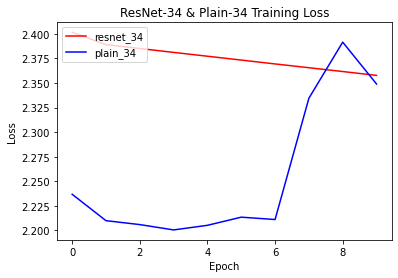

In [28]:
import matplotlib.pyplot as plt

#ResNet-34, Plain-34 Validation Loss 시각화

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('ResNet-34 & Plain-34 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 Validation Accuracy

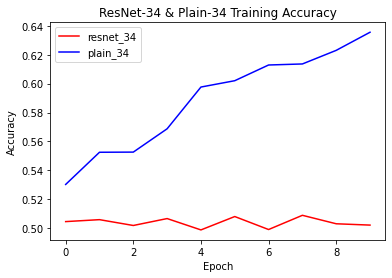

In [29]:
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

<h2>ResNet-50 와 Plain-50 비교</h2>

ResNet-50 & Plain-50 Validation Loss

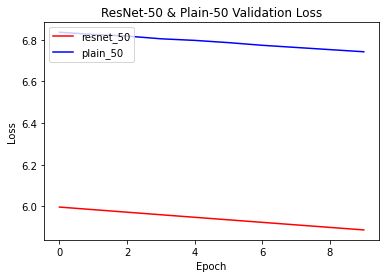

In [30]:
# ResNet-50, Plain-50 Validation Loss 시각화

plt.plot(history_resnet_50.history['val_loss'], 'r')
plt.plot(history_plain_50.history['val_loss'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()
     

ResNet-50 & Plain-50 Validation Accuracy

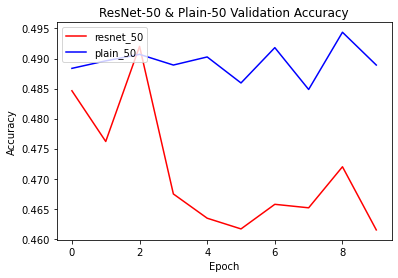

In [31]:
# ResNet-50, Plain-50 Validation Accuracy 시각화

plt.plot(history_resnet_50.history['val_accuracy'], 'r')
plt.plot(history_plain_50.history['val_accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 & ResNet-50 & Plain-50 Validation Loss

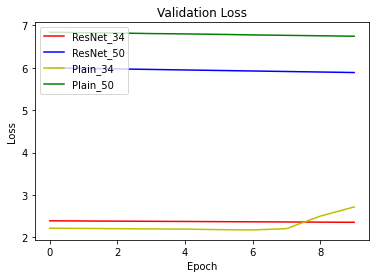

In [32]:
plt.plot(history_resnet_34.history['val_loss'], 'r')
plt.plot(history_resnet_50.history['val_loss'], 'b')
plt.plot(history_plain_34.history['val_loss'], 'y')
plt.plot(history_plain_50.history['val_loss'], 'g')
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')
plt.show()
     

ResNet-34 & Plain-34 & ResNet-50 & Plain-50 Validation Accuracy

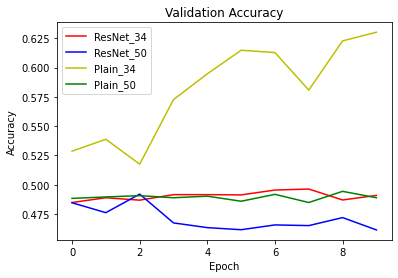

In [33]:
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_resnet_50.history['val_accuracy'], 'b')
plt.plot(history_plain_34.history['val_accuracy'], 'y')
plt.plot(history_plain_50.history['val_accuracy'], 'g')
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 Training Loss

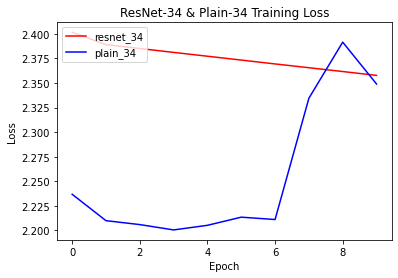

In [34]:
# ResNet-34, Plain-34 Training Loss 시각화

plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('ResNet-34 & Plain-34 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

epoch 6 쯤에서 overfiting이 발생하는 듯 loss가 갑작스럽게 증가하는 모습을 볼 수 있었습니다

ResNet-34 & Plain-34 Training Accuracy

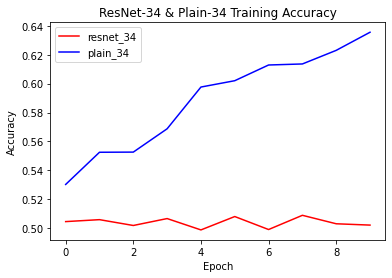

In [35]:
# ResNet-34, Plain-34 Training Accuracy 시각화

plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_plain_34.history['accuracy'], 'b')
plt.title('ResNet-34 & Plain-34 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_34', 'plain_34'], loc='upper left')
plt.show()

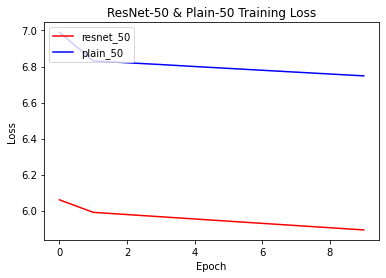

In [36]:
# ResNet-50, Plain-50 Training Loss 시각화

plt.plot(history_resnet_50.history['loss'], 'r')
plt.plot(history_plain_50.history['loss'], 'b')
plt.title('ResNet-50 & Plain-50 Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()

ResNet-50 & Plain-50 Training Accuracy

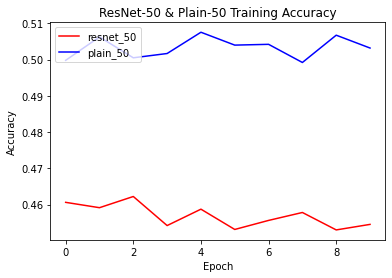

In [37]:
# ResNet-50, Plain-50 Training Accuracy 시각화

plt.plot(history_resnet_50.history['accuracy'], 'r')
plt.plot(history_plain_50.history['accuracy'], 'b')
plt.title('ResNet-50 & Plain-50 Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50', 'plain_50'], loc='upper left')
plt.show()
     

ResNet-34 & Plain-34 & ResNet-50 & Plain-50 Training Loss

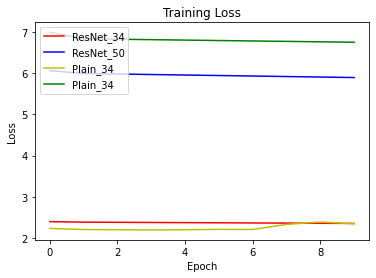

In [38]:
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_resnet_50.history['loss'], 'b')
plt.plot(history_plain_34.history['loss'], 'y')
plt.plot(history_plain_50.history['loss'], 'g')
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_34'], loc='upper left')
plt.show()

ResNet-34 & Plain-34 & ResNet-50 & Plain-50 Training Accuracy

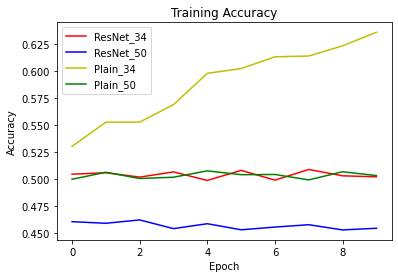

In [39]:
plt.plot(history_resnet_34.history['accuracy'], 'r')
plt.plot(history_resnet_50.history['accuracy'], 'b')
plt.plot(history_plain_34.history['accuracy'], 'y')
plt.plot(history_plain_50.history['accuracy'], 'g')
plt.title('Training Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['ResNet_34','ResNet_50','Plain_34','Plain_50'], loc='upper left')
plt.show()

<h3>validation loss</h3>

·epoch를 적게한 영향으로 인한 것인지 loss가 줄어드는 모습보다 일정한 모습을 확인할 수 있었다.<br>
·모델이 깊어지면 Loss 값이 높아지는 것을 확인할 수 있고, 의외로 plain_34가 높은 accuracy가 높았다.

<h3>Validaion Accuracy</h3>

·Plain-34가 가장 높고 Plain-50, ResNet-34와 ResNet-50의 Validation Accuracy는 비슷한 것을 알 수 있다.<br>
·ResNet-34와 Plain-50, ResNet_50의 그래프를 보면 처음과 비슷한 Accuracy를 가지고 그닥 상승하지 않음을 알 수있다.<br>
·Plain-34은 다른 모델들에 비하여 성능이 우수하다는 것을 확인할 수 있었다.<br>

<h2>회고</h2>

해당 코드들로 훈련을 시킬 때까지는 resnet 모델의 accuracy가 당연히 높을 줄 알았으나 결과는 전혀 달리 나와 좀 놀랐습니다.<br>
ResNet-34, Plain-34 Training Loss 시각화에서 보면 갑자기 Plain-34에서 loss가 갑작스럽게 상승하는 것을 볼 수 있습니다. 이것이 아마도 overfiting과 관련있을 것이라 생각합니다.

goingdeeper에서 논문을 살펴보며 코드를 구상한다고 생각하니 난이도가 많이 상승한 것을 느낄 수 있었습니다.<br>
앞으로는 하루에 한 개의 논문을 살펴보는 습관을 가져야겠다는 생각이 들었습니다.